<!-- Autoheader begin -->
<hr/>
<div id="navtitle_2_1_py" style="text-align:center; font-size:16px">II.1 Population Inversion in a Two-Level-System using Parameter Optimization</div>
<hr/>
<table style="width: 100%">
  <tr>
    <th rowspan="2" style="width:33%; text-align:center; font-size:16px">
        <a href="py_exercise_1_3_chirp.ipynb">$\leftarrow$ previous notebook </a><br>
        <a href="py_exercise_1_3_chirp.ipynb" style="font-size:13px">I.3 Interaction of a Two-Level-System with a Chirped Laser Pulse</a>
    </th>
    <td style="width:33%; text-align:center; font-size:16px">
        <a href="py_exercise_1_1_TLS.ipynb">$\uparrow$ previous part $\uparrow$</a><br>
        <a href="py_exercise_1_1_TLS.ipynb" style="font-size:13px">I.1 Population Inversion in a Two-Level-System</a>
    </td>
    <th rowspan="2" style="width:33%; text-align:center; font-size:16px">
        <a href="py_exercise_2_2_lambda.ipynb">next notebook $\rightarrow$</a><br>
        <a href="py_exercise_2_2_lambda.ipynb" style="font-size:13px">II.2 Parameter Optimization for STIRAP</a>
    </th>
  </tr>
  <tr style="width: 100%">
    <td style="width:33%; text-align:center; font-size:16px">
        <a href="py_exercise_3_1_TLS.ipynb" style="font-size:13px">III.1 Population Inversion in a Two-Level-System using Krotov's Method</a><br>
        <a href="py_exercise_3_1_TLS.ipynb">$\downarrow$ next part $\downarrow$</a>
    </td>
  </tr>
</table>

<div style="text-align: right;font-size: 16px"><a href="../Julia/jl_exercise_2_1_TLS.ipynb">👉 Julia version</a></div>

---
<!-- Autoheader end -->

# Population Inversion in a Two-Level-System using Parameter Optimization

$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2} \mid
#2\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}$

This notebook contains the code for running an optimization to achieve a
population inversion in a two-level system.
You will learn how to use the Python `NLopt` package in order to optimize a
pulse shape by tuning the pulse parameters such as the pulse duration and intensity. The goal of the optimization is to drive the two-level system such that all the population is perfectly transferred from the ground to the excited state, similar to [Exercise I.1](py_exercise_1_1_TLS.ipynb). In this notebook we employ parameter optimization which searches the optimization landscape directly by evaluating the optimization functionals at different points of the parameter space.

## Setup

First, we need to load some of the libraries that we will need throughout
this notebook.

In [2]:
import matplotlib.pylab as plt
import numpy as np  # Package for numerical functions such as cos, sin, etc.
import qutip  # QUantum Toolbox In Python
import nlopt  # Package for optimization

# Some utilities for showing hints and solutions
from utils.exercise_2_TLS import *

# Some functions for easy access:
from numpy import pi, sqrt, exp, sin, cos

### Defining the Hamiltonian

We begin by defining the Hamiltonian, the guess field as well as the initial and target states.

The Hamiltonian $\op{H}_{0} = - \frac{\omega}{2} \op{\sigma}_{z}$ represents
a simple qubit with energy level splitting $\omega$ in the basis
$\{\ket{0},\ket{1}\}$. The control field $\epsilon(t)$ is assumed to couple
via the Hamiltonian $\op{H}_{1}(t) = \epsilon(t) \op{\sigma}_{x}$ to the
qubit, i.e., the control field effectively drives transitions between both
qubit states.

In this notebook, we will optimize the amplitude $E_0$ and pulse length
$\Delta T = t_f - t_i$ of a pulse with a Blackman shape. For simplicity, we
choose the carrier frequency of the pulse to match the energy splitting of
the qubits. The pulse is then defined as

$$
\epsilon(t) = E_0 \cos(\omega t) B(t; t_i, t_f)
$$

with the Blackman shape defined as

$$
B(t; t_i, t_f) =
\frac{1}{2}\left(
    1 - a - \cos\left(2\pi \frac{t - t_i}{t_f - t_i}\right)
    + a \cos\left(4\pi \frac{t - t_i}{t_f - t_i}\right)
\right)\,, \text{ if } t_i < t < t_f;
\qquad B(t; t_i, t_f) = 0 \text{ otherwise}
$$

with $a = 0.16$. A Blackman shape looks nearly identical to a Gaussian with a
6-sigma interval between $t_i$ and $t_f$. Unlike the Gaussian, however, it
will go exactly to zero at the edges. Thus, Blackman pulses are often
preferable to Gaussians.

In [3]:
def make_blackman_pulse(omega, E_0, t_i, t_f):
    """Constructor a control function with Blackman shaped pulse.

    The resulting function takes parameters `t` and `args`, where `args` is
    ignored.

    Args:
        omega (float): carrier frequency of the pulse
        E_0   (float): pulse amplitude
        t_i   (float): start of the pulse
        t_f   (float): end of the pulse
    """

    def blackman_pulse(t, args):
        return (
            (E_0 / 2.0)
            * cos(omega * t)
            * (
                1
                - 0.16
                - cos(2 * pi * (t - t_i) / (t_f - t_i))
                + 0.16 * cos(4 * pi * (t - t_i) / (t_f - t_i))
            )
            * np.where(np.logical_and(t > t_i, t < t_f), 1, 0)
        )

    return blackman_pulse


def ham_and_states(omega, E_0, t_i, t_f):
    """Two-level-system Hamiltonian

    Args:
        omega (float): energy separation of the qubit levels
        E_0    (float): pulse amplitude
        t_i    (float): start of the pulse
        t_f    (float): end of the pulse
    """
    H0 = -0.5 * omega * qutip.operators.sigmaz()
    H1 = qutip.operators.sigmax()

    ket0 = qutip.Qobj(np.array([1, 0]))  # State |0⟩
    ket1 = qutip.Qobj(np.array([0, 1]))  # State |1⟩

    return ([H0, [H1, make_blackman_pulse(omega, E_0, t_i, t_f)]], ket0, ket1)

## Simulating the dynamics with the guess field

Before starting with the actual optimization, we first simulate the
dynamics under a guess field $\epsilon_{0}(t)$. To this end, we need to define
the time grid of the dynamics. We define the initial state to
be at time $t=0$ and consider a total propagation time of $T=10$. The entire
time grid is divided into $5000$ equidistant time steps (corresponding to 5001 time grid
points).

In [4]:
T = 10.0
nt = 5001

tlist = np.linspace(0, T, nt)

Next we define the guess pulse itself.
Note that in the following, it is more convenient to use the
pulse length `ΔT = t_f - t_i` instead of `t_i` and `t_f` as
a parameter, since it reduces the number of control parameters by one.

In [5]:
omega = 12.0 # carrier frequency, should be sufficiently large
E_0 = 0.5    # pulse amplitude
ΔT  = 5.0    # pulse length
# make pulse symmetric around the middle of the time interval
t_i = T/2 - ΔT/1
t_f = T/2 + ΔT/2

H, ket0, ket1 = ham_and_states(omega, E_0, t_i, t_f)

Then, we solve the equation of motion for the initial state
$\ket{\Psi_{\init}}=\ket{0}$ for the evolution generated by the Hamiltonian $\op{H}(t)$. To this end, we define the projectors $\op{P}_0 = \ket{0}\bra{0}$
and $\op{P}_1 = \ket{1}\bra{1}$ to track their expectation values.

In [6]:
proj0 = ket0 * ket0.dag()
proj1 = ket1 * ket1.dag()

output = qutip.mesolve(H, ket0, tlist, e_ops=[proj0, proj1])

Now we plot the absolute value of the field together with the population of
the two levels as a function of time.

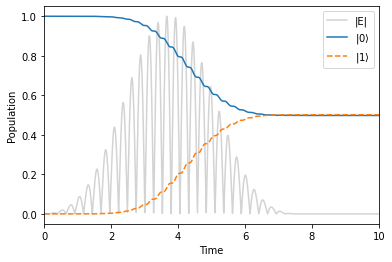

In [7]:
E = H[1][1](tlist, args=None)  # extract pulse from Hamiltonian

fig, ax = plt.subplots()
ax.plot(tlist, np.abs(E)/np.abs(E).max(), '-', color='lightgrey', label='|E|')
ax.plot(tlist, output.expect[0], '-', label=r'$|0\rangle$')
ax.plot(tlist, output.expect[1], '--', label=r'$|1\rangle$')
ax.set_xlim(tlist.min(), tlist.max())
ax.set_xlabel('Time')
ax.set_ylabel('Population')
ax.legend()
plt.show()

## Problem 0 - Pulse parameterization

As you can see, the guess pulse does a bad job in transferring the population
from the ground to the excited state. Therefore, we first try to optimize the
pulse parameters by hand to achieve a full population inversion.

We begin by familiarizing ourselves with the pulse parameterization. For the
Blackman shape, `E_0` controls the pulse amplitude, and `ΔT` determines the
length of the pulse. Try changing the arguments of
`evolve_and_plot_parameterized_pulse`, such that you achieve an infidelity
below 0.001.

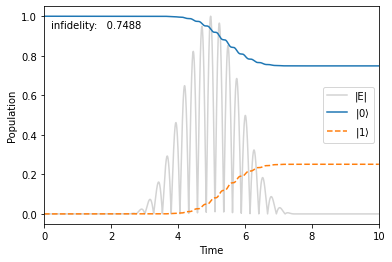

In [8]:
def evolve_and_plot_parameterized_pulse(E_0, ΔT, omega=omega, tlist=tlist):

    T = tlist[-1]
    t_i = T / 2 - ΔT / 2
    t_f = T / 2 + ΔT / 2

    H, ket0, ket1 = ham_and_states(omega, E_0, t_i, t_f)
    E = H[1][1](tlist, args=None)  # extract the pulse from H

    proj0 = ket0 * ket0.dag()
    proj1 = ket1 * ket1.dag()

    output = qutip.mesolve(H, ket0, tlist, e_ops=[proj0, proj1])
    infidelity = 1 - output.expect[1][-1]

    fig, ax = plt.subplots()
    ax.plot(
        tlist, np.abs(E) / np.abs(E).max(), '-', color='lightgrey', label='|E|'
    )
    ax.plot(tlist, output.expect[0], '-', label=r'$|0\rangle$')
    ax.plot(tlist, output.expect[1], '--', label=r'$|1\rangle$')
    ax.set_xlim(tlist.min(), tlist.max())
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    plt.text(0.2, 0.94, 'infidelity: {:8.4f}'.format(infidelity))
    plt.legend()

evolve_and_plot_parameterized_pulse(E_0=0.5, ΔT=5.0)

In [9]:
problem_0.hint


Start varying parameters to get close to a population of 1 in state $\ket{1}$.
Find an order-of-magnitude value for each free parameter. Then iterate over
the parameters and bisect the value for each parameter to refine the value.


In [10]:
problem_0.solution


A reasonably good set of parameters obtained by hand might be this:

```python
evolve_and_plot_parameterized_pulse(E_0=0.92,ΔT=8.0)
```


## Initialize optimization

Now we can turn towards optimization. To this end, we use the optimization methods provided by the `nlopt` package. For simplicity, we use the well-known Nelder-Mead method. Note, however, that `nlopt` allows for a wide range of different methods.

The `nlopt` for optimization requires a `loss` function, i.e. the optimization functional, which takes a set of real-valued parameters (called `x` here). One may also provide a function for the gradient but this is only required if a gradient-based optimization method is employed, which we do not study in this notebook on gradient-free optimization. Hence, we set the gradient to `None`.

The `loss` function takes the list `x`, which contains our optimization parameters, i.e., the amplitude $E_{0}$ and the pulse duration $\Delta T$ on input, and returns the infidelity. Specifically, `loss` returns zero if and only if the dynamics obtained from the parameters in the set `x` transfers the initial state $\ket{\Psi(0)}$ perfectly into the target state, i.e.,

$$
\ket{\Psi(0)} =
\ket{0}
\longrightarrow
\ket{\Psi\left(T\right)} =
\ket{1}
$$

In [17]:
def population(state, level):
    return abs(state[level][0][0]) ** 2

def loss(x, grad=None):
    global iterations
    global obtained_fidelities
    global omega
    global tlist
    iterations += 1
    # map the optimization parameters from the set x to the amplitude and duration
    E_0 = x[0]
    ΔT = x[1]
    T = tlist[-1]
    t_i = T / 2 - ΔT / 2
    t_f = T / 2 + ΔT / 2
    # define the Hamiltonian
    H, ket0, ket1 = ham_and_states(omega, E_0, t_i, t_f)

    # simulate the dynamics
    output = qutip.mesolve(H, ket0, tlist)

    # define the fidelity of the outcome
    def fid(psi):
        return population(psi, level=1)

    # calculate the fidelity for the dynamics under the parameters from set x
    fidelity = fid(output.states[-1])
    obtained_fidelities.append(fidelity)

    print(
        f"Iteration: {iterations:}, current fidelity {fidelity:8.4f}", end="\r"
    )
    # return the error (this is our optimization functional)
    return 1.0 - fidelity

## Problem 1 - Run optimization

Next, we can run the actual optimization. It requires us to define lower and
upper bounds for all parameters that should be optimized. In our case, we
choose

$$
0 \leq E_{0} \leq 10,
\qquad
0 \leq \Delta T \leq T.
$$

Note that we need to provide guess values for the two parameters. The order
that the parameters should appear in is as follows

* `E_0`
* `ΔT`

The choice of the guess values will often have an appreciable impact on the general success of the optimized solution and can even affect its form since many optimization problems allow for many different solutions.
Your task is now to fill in the upper optimization bounds and to try different
guesses to evaluate their impact on the optimization.

In [23]:
# define lower and upper bounds for E_0 and pulse duration that are to be optimized
bounds_lower = [0,0]
bounds_upper = [10.0,T]

## determine guess parameters for all parameters that are optimized
# set guess parameters for all parameters that are optimized
guess = [0.5,5.0]

# specify the optimization method and the number of parameters that should be optimized
# (given here by len(bounds_lower))
opt = nlopt.opt(nlopt.LN_NELDERMEAD, len(bounds_lower))

# set the lower and upper bound for the optimization
opt.set_lower_bounds(bounds_lower)
opt.set_upper_bounds(bounds_upper)
opt.set_maxeval(500)

# set the objective that should be optimized (note that this implies minimization)
opt.set_min_objective(loss)

# fidelity above which the optimization should be stopped
fid_min = 0.999

# define below which value, i.e., error, to stop the optimization
opt.set_stopval(1.-fid_min)

# perform the optimization
obtained_fidelities = []
iterations = 0
x = opt.optimize(guess)

print('\n\nHighest fidelity reached: {:6.2f}%'.format(100.0*(1-opt.last_optimum_value())))
if opt.last_optimum_value() > 1-fid_min:
    print('\tbad guess, please try again!')
else:
    print('\tcongratulations, you have obtained population inversion!')

Iteration: 15, current fidelity   0.9995

Highest fidelity reached:  99.95%
	congratulations, you have obtained population inversion!


In [5]:
# problem_1.hint

In [19]:
problem_1.solution


```python
bounds_lower = [0,0]
bounds_upper = [10.0, T]
guess = [0.5, 5.0]
```


Text(0, 0.5, 'fidelity')

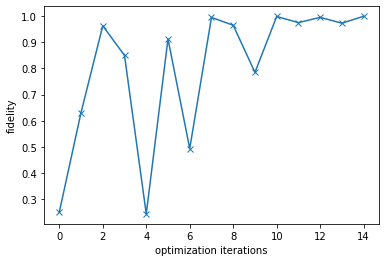

In [21]:
# plot the results
plt.plot(range(len(obtained_fidelities)), obtained_fidelities, marker='x')
plt.xlabel('optimization iterations')
plt.ylabel('fidelity')

## Analyze optimization results

After the optimization we can verify the optimization result by plotting the
pulse as well as the resulting dynamics.

E_0 = 1.041
ΔT  = 7.236


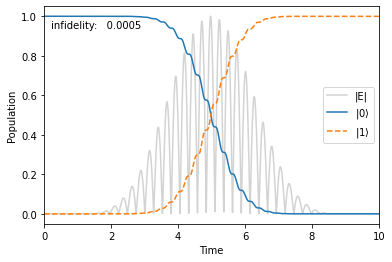

In [22]:
evolve_and_plot_parameterized_pulse(E_0=x[0], ΔT=x[1])
print('E_0 = {:.3f}\nΔT  = {:.3f}'.format(x[0], x[1]))

Try to vary the guess parameters and obtain different solutions. Can
you obtain a pulse which only brings half the population to the excited state? Or a pulse which makes the population go to the excited state and then perfectly back to the ground state again?

It turns out that for these optimization tasks in this problem there is an infinite amount of solutions.
This is because already a single parameter would be sufficient to
achieve the target objective and we over-parameterize the problem with
two parameters. However, in an actual experiment, there are often additional
constraints, e.g., on the maximum amplitude. Set the upper bound for
$E_0$ to $2.0$ (make sure to set the guess value a bit below that).
Can you still obtain solutions with $\Delta T <3.5$?

## Next steps

To continue exploring the optimization of parameterized pulses with NLOpt in a more complex system, you can proceed with [Exercise II.2](py_exercise_2_2_lambda.ipynb) for the optimization of STIRAP in a three-level system.
Alternatively, if you are interested in optimization with a gradient-based approach, we recommend to have a look at [Exercise III.1](py_exercise_3_1_TLS.ipynb) in which Krotov's method is used for the opimization you studied in this notebook.

<!-- Autofooter begin -->

---

[⬆︎ jump to top](#navtitle_2_1_py)
<!-- Autofooter end -->